In [66]:

import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

from typing import Optional, Union, Callable, Tuple  # Type hints
import e3nn_jax as e3nn  # E(3)-equivariant neural networks
import jax  # Accelerated numerical computing and automatic differentiation
import optax  # Gradient-based optimization
import jax.numpy as jnp  # Compatibility with JAX functions
import matplotlib.pyplot as plt  # Data visualization
from matplotlib.lines import Line2D  # Custom line styles
import plotly  # Interactive data visualization
import plotly.graph_objects as go  # Interactive plots
import pandas as pd  # Data manipulation and analysis
from tqdm import tqdm  # Progress bars and iteration monitoring
from src.spectra import Spectra, radial_cutoff, voronoi_cutoff, with_peaks_at

def visualize(geometry):
    """
    """
    sig = with_peaks_at(geometry, lmax=4)

    layout = go.Layout(
        scene=dict(
            xaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(255,255,255,255)', range=[-2.5, 2.5]),
            yaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(255,255,255,255)', range=[-2.5, 2.5]),
            zaxis=dict(title='', showticklabels=False, showgrid=False, zeroline=False, backgroundcolor='rgba(255,255,255,255)', range=[-2.5, 2.5]),
            bgcolor='rgba(255,255,255,255)',
            aspectmode='cube',
            camera=dict(
                eye=dict(x=0.5, y=0.5, z=0.5)
            )
        ),
        plot_bgcolor='rgba(255,255,255,255)',
        paper_bgcolor='rgba(255,255,255,255)',
        margin=dict(l=0, r=0, t=0, b=0),
        showlegend=True
    )

    spherical_harmonics_trace = go.Surface(e3nn.to_s2grid(sig, 100, 99, quadrature="soft").plotly_surface(radius=0.5, scale_radius_by_amplitude=True), name="spherical_harmonics_trace")
    atoms_trace = go.Scatter3d(x=geometry[:, 0], y=geometry[:, 1], z=geometry[:, 2], mode='markers', marker=dict(size=5, color='black'), name="atoms_trace")
    return go.Figure(data=[spherical_harmonics_trace, atoms_trace], layout=layout)

def colorplot(arr: jnp.ndarray):
    """Helper to plot a 1D array as a color plot."""
    plt.figure(figsize=(15, 1))
    plt.axis("off")
    vmax = jnp.maximum(jnp.abs(jnp.min(arr)), jnp.max(arr))
    return plt.imshow(arr[None, :], cmap="RdBu", vmin=-vmax, vmax=vmax)


In [67]:
true_geometry = jnp.array([
    [1, 0, 0],
    [-0.5, jnp.sqrt(3)/2, 0],
    [-0.5, -jnp.sqrt(3)/2, 0]
])
# true_geometry = jnp.array([
#     [1, 0, 0],
#     [0, 1, 0],
# ])

true_sig = with_peaks_at(true_geometry, lmax=4)

bispectrum = Spectra(lmax=4, order=2)
true_spectrum = bispectrum.compute_geometry(true_geometry)

params, all_losses, all_grad_norms = bispectrum.invert(true_spectrum, n_points=3)

Step 0, Loss: 6.198108167154714e-05
Step 100, Loss: 3.0920498829800636e-05
Step 200, Loss: 3.0919454729883e-05
Step 300, Loss: 3.091945109190419e-05
Step 400, Loss: 3.0919454729883e-05
Step 500, Loss: 3.0919454729883e-05
Step 600, Loss: 3.0919454729883e-05
Step 700, Loss: 3.0919454729883e-05
Step 800, Loss: 3.0919454729883e-05
Step 900, Loss: 3.0919454729883e-05


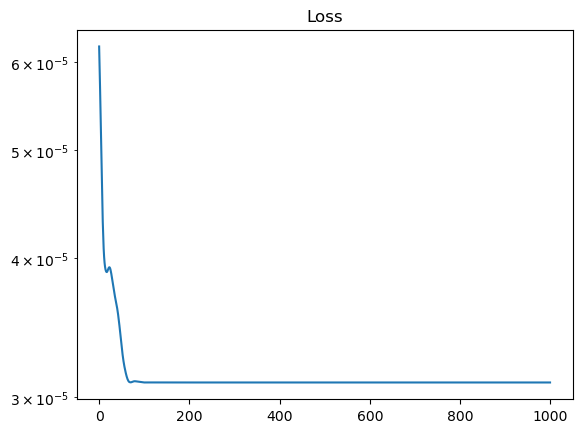

In [68]:
plt.plot(all_losses)
plt.title("Loss")
plt.yscale("log")
plt.show()

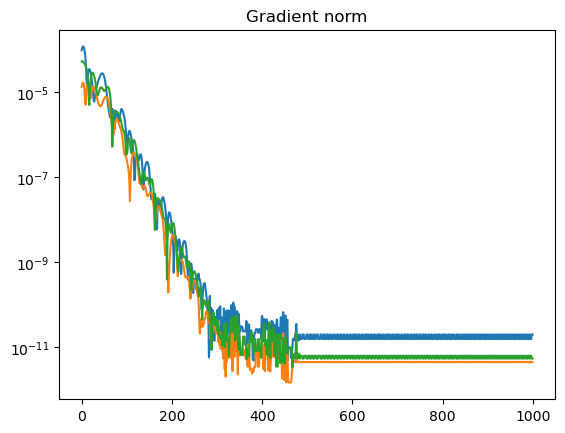

In [69]:
plt.plot(all_grad_norms)
plt.title("Gradient norm")
plt.yscale("log")
plt.show()

In [70]:
predicted_geometry = params["predicted_geometry"]

In [71]:
visualize(true_geometry)

In [72]:
visualize(predicted_geometry)

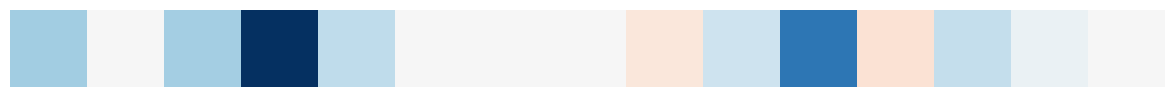

In [73]:
colorplot(true_spectrum)

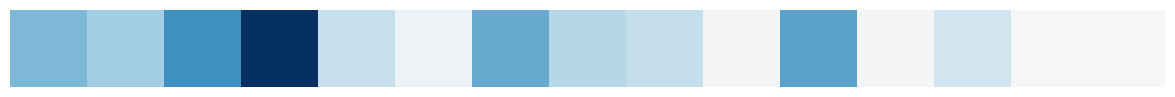

In [74]:
colorplot(bispectrum.compute_geometry(predicted_geometry))

In [75]:
x = true_spectrum

In [76]:
y = bispectrum.compute_geometry(predicted_geometry)

In [77]:
(x - y) ** 2 / 2

Array([0.00000000e+00, 5.59107939e-05, 1.57092600e-05, 3.61776183e-05,
       4.17217279e-06, 1.35005450e-06, 1.17356794e-04, 3.80669771e-05,
       6.92930771e-05, 2.86933009e-05, 6.90704910e-05, 1.94834993e-05,
       5.50523282e-06, 3.00249553e-06, 4.78365683e-19], dtype=float32)

In [78]:
optax.l2_loss(x, y)

Array([0.00000000e+00, 5.59107939e-05, 1.57092600e-05, 3.61776183e-05,
       4.17217279e-06, 1.35005450e-06, 1.17356794e-04, 3.80669771e-05,
       6.92930771e-05, 2.86933009e-05, 6.90704910e-05, 1.94834993e-05,
       5.50523282e-06, 3.00249553e-06, 4.78365683e-19], dtype=float32)